In [ ]:
# Autokeras + ONE-HOT

In [24]:
#numpy
import numpy as np
print("NumPy version:", np.__version__)
#проверка CUDA
import tensorflow as tf
print("Доступные GPU:", tf.config.list_physical_devices('GPU'))
print("Версия CUDA:", tf.sysconfig.get_build_info()["cuda_version"])
print("Версия cuDNN:", tf.sysconfig.get_build_info()["cudnn_version"])
#проверка CUDA_tensorflow
print("TensorFlow собран с поддержкой CUDA:", tf.test.is_built_with_cuda())
print("TensorFlow собран с поддержкой GPU:", tf.test.is_built_with_gpu_support())
#Проверка tensorflow
!conda list tensorflow
#Проверка версии CUDA
!nvcc --version
#cudnn
!conda list cudnn

NumPy version: 2.3.4
Доступные GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Версия CUDA: 12.5.1
Версия cuDNN: 9
TensorFlow собран с поддержкой CUDA: True
TensorFlow собран с поддержкой GPU: True
# packages in environment at /home/oleg/miniconda3/envs/tensflow:
#
# Name                          Version          Build            Channel
tensorflow                      2.19.1           pypi_0           pypi
tensorflow-io-gcs-filesystem    0.37.1           pypi_0           pypi
tensorflow-text                 2.19.0           pypi_0           pypi
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:23:50_PST_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0
# packages in environment at /home/oleg/miniconda3/envs/tensflow:
#
# Name                     Version          Build            Channel
nvidia-cudnn-cu12          9.14.0.64        pypi_0           pypi


In [3]:
!nvidia-smi

Wed Oct 22 17:16:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P8             11W /  200W |    1632MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Оптимизация TensorFlow
import tensorflow as tf
tf.config.optimizer.set_jit(True)  # Включение XLA-компиляции
tf.config.threading.set_intra_op_parallelism_threads(8)
#tf.config.threading.set_inter_op_parallelism_threads(8)

# Для GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            #tf.config.experimental.set_memory_limit(gpu, 8192)  # Лимит 8GB
    except RuntimeError as e:
        print(e)

In [8]:
import tensorflow as tf
import autokeras as ak

print(tf.__version__)

print(f"AutoKeras version: {ak.__version__}")

# Посмотрим все доступные блоки
available_blocks = [attr for attr in dir(ak) if 'Block' in attr or 'Head' in attr]
print("Доступные блоки в AutoKeras 2.0.0:")
for block in sorted(available_blocks):
    print(f"  - {block}")

2.20.0
AutoKeras version: 2.0.0
Доступные блоки в AutoKeras 2.0.0:
  - BertBlock
  - Block
  - ClassificationHead
  - ConvBlock
  - DenseBlock
  - EfficientNetBlock
  - Head
  - ImageBlock
  - RNNBlock
  - RegressionHead
  - ResNetBlock
  - TextBlock
  - XceptionBlock


In [9]:
# Текущая директория + путь к датасету

import os
HOME = os.getcwd()
print(HOME)
print('-----------------------')
# Пути
IMAGE_PATH = "/home/oleg/projects/datasets/construction"
#dataset_path = "./animals"
#dataset_path = "./cars_pretrained"
#dataset_path = "./construction"
#IMAGE_PATH = dataset_path
os.listdir(IMAGE_PATH)

/home/oleg/projects/ML
-----------------------


['mining_loader',
 'bulldozer',
 'ice_rink',
 'dump_truck',
 'excavator',
 'person',
 'car',
 'truck_crane']

📊 АНАЛИЗ ДАТАСЕТА:
  bulldozer: 194 файлов
  car: 1586 файлов
  dump_truck: 797 файлов
  excavator: 316 файлов
  ice_rink: 293 файлов
  mining_loader: 514 файлов
  person: 969 файлов
  truck_crane: 321 файлов
📈 ИТОГО: 4990 изображений, 8 классов


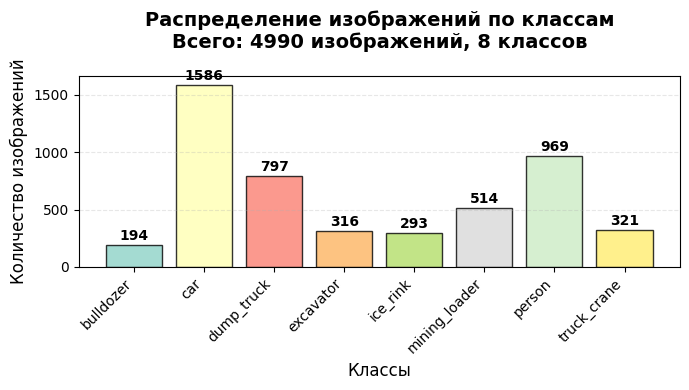

In [11]:
# Простой анализ датасета с визуализацией

import os
import matplotlib.pyplot as plt
import numpy as np

def analyze_dataset_simple(dataset_path):
    """
    Простой анализ датасета с визуализацией
    """
    # Проверяем существование пути
    if not os.path.exists(dataset_path):
        print(f"❌ Ошибка: путь '{dataset_path}' не существует")
        return None
    
    # Получаем список классов
    class_names = [d for d in os.listdir(dataset_path) 
                  if os.path.isdir(os.path.join(dataset_path, d))]
    class_names.sort()
    
    if not class_names:
        print("❌ В датасете не найдено папок с классами")
        return None
    
    # Подсчет файлов
    class_counts = {}
    total_files = 0
    
    print("📊 АНАЛИЗ ДАТАСЕТА:")
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        count = len(image_files)
        class_counts[class_name] = count
        total_files += count
        print(f"  {class_name}: {count} файлов")
    
    print(f"📈 ИТОГО: {total_files} изображений, {len(class_names)} классов")
    
    # Визуализация
    plt.figure(figsize=(7, 4))
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    # Создаем диаграмму
    bars = plt.bar(classes, counts, color=plt.cm.Set3(np.linspace(0, 1, len(classes))), 
                   edgecolor='black', alpha=0.8)
    
    # Настройки графика
    plt.title(f'Распределение изображений по классам\nВсего: {total_files} изображений, {len(class_names)} классов', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Классы', fontsize=12)
    plt.ylabel('Количество изображений', fontsize=12)
    
    # Поворачиваем подписи и выравниваем
    plt.xticks(rotation=45, ha='right')
    
    # Добавляем значения на столбцы
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Добавляем сетку для удобства чтения
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Настраиваем отступы
    plt.tight_layout()
    
    plt.show()
    
    return {'class_names': class_names, 'class_counts': class_counts, 'total_files': total_files}

# ИСПОЛЬЗОВАНИЕ:
# Просто вызовите функцию с путем к вашему датасету
result = analyze_dataset_simple(IMAGE_PATH)

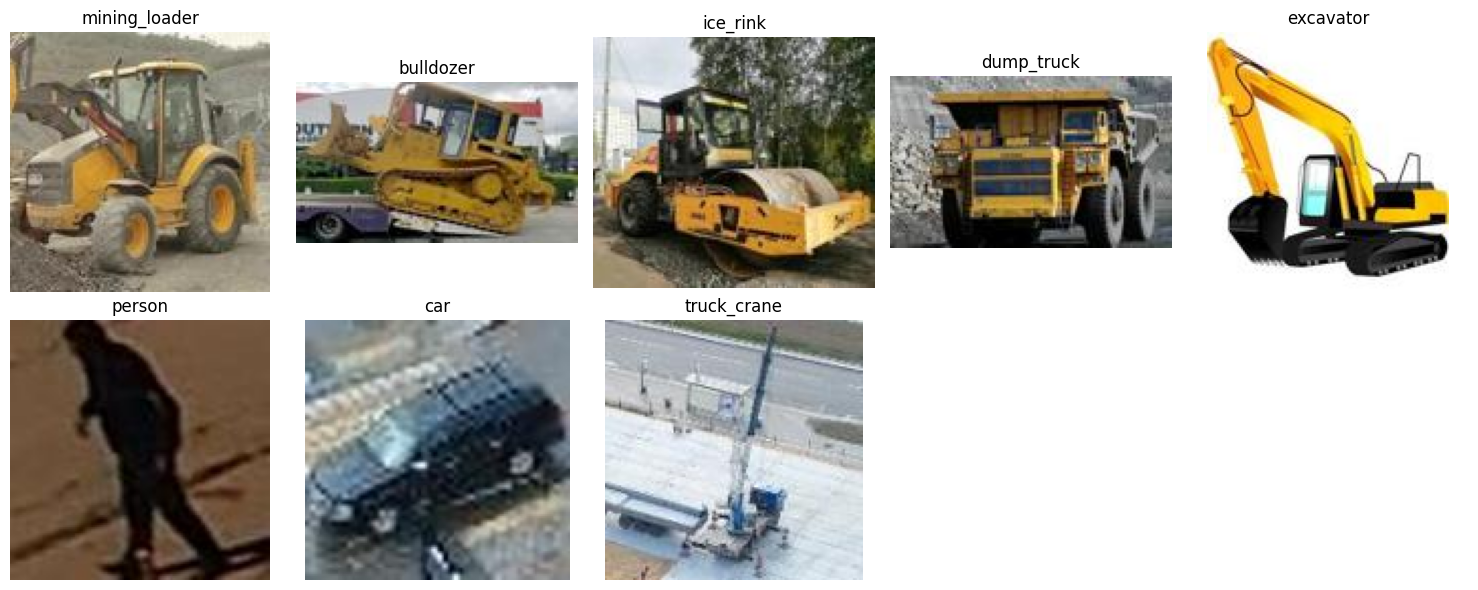

🎲 Показано по 1 случайному изображению из 8 категорий


In [12]:
# Показано по 1 случайному изображению из каждой категорий

from PIL import Image
import os
import matplotlib.pyplot as plt
import random

# Создаем график 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

categories = os.listdir(IMAGE_PATH)
plot_index = 0

for category in categories:
    category_path = os.path.join(IMAGE_PATH, category)
    file_names = os.listdir(category_path)
    
    # Берем 1 случайное изображение из каждой категории
    if file_names:
        random_file = random.choice(file_names)
        img_path = os.path.join(category_path, random_file)
        img = Image.open(img_path)
        
        axes[plot_index].imshow(img)
        axes[plot_index].set_title(f"{category}", fontsize=12)
        axes[plot_index].axis('off')
        plot_index += 1

# Скрываем лишние subplot'ы
for i in range(plot_index, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"🎲 Показано по 1 случайному изображению из {plot_index} категорий")

In [26]:
# ✅ ПРАВИЛЬНЫЙ способ загрузки для AutoKeras

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import autokeras as ak
import time
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 64

train_data, validation_data = image_dataset_from_directory(
    IMAGE_PATH,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size
)

# Минимальная проверка
CLASS_NAMES = train_data.class_names  # ✅ У tf.data.Dataset ЕСТЬ class_names!
CLASS_COUNT = len(CLASS_NAMES)

#AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(AUTOTUNE)
validation_data = validation_data.cache().prefetch(AUTOTUNE)

print(f"🏷️  Классы: {CLASS_NAMES}")
print(f"🔢 Количество классов: {CLASS_COUNT}")

# Проверка одного батча
for images, labels in train_data.take(1):
    print(f"📐 Батч: {images.shape}, метки: {labels.shape}")
    break

Found 4990 files belonging to 8 classes.
Using 3992 files for training.
Using 998 files for validation.
🏷️  Классы: ['bulldozer', 'car', 'dump_truck', 'excavator', 'ice_rink', 'mining_loader', 'person', 'truck_crane']
🔢 Количество классов: 8
📐 Батч: (64, 224, 224, 3), метки: (64, 8)


2025-10-22 19:44:56.620688: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
import gc
import tensorflow as tf

# 🔄 ПОЛНАЯ ОЧИСТКА
tf.keras.backend.clear_session()
gc.collect()

0

In [23]:
# The user specifies the high-level architecture.
import autokeras as ak
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

'''
input_node
ImageAugmentation
Normalization
ResNetBlock
ConvBlock
SpatialReduction
DenseBlock
ClassificationHead
'''

'''
Изображение (224, 224, 3)
    ↓
ImageAugmentation
    ↓  
Normalization
    ↓
ResNetBlock → (7, 7, 512)
    ↓
ConvBlock → (7, 7, 256)     # ← ДО SpatialReduction!
    ↓
SpatialReduction → (256,)   # ← ПОСЛЕ ConvBlock
    ↓
DenseBlock → (128,)
    ↓
ClassificationHead → (8,)
'''

'''
Стандартная структура классификатора изображений:

Input → Входные данные

Augmentation → Аугментация (опционально, но рекомендуется)

Normalization → Нормализация

Backbone (ResNet/Conv blocks) → Извлечение признаков ✅

Global Pooling → Пространственное сокращение ✅

Dense/MLP → Классификация на признаки ✅

Classification Head → Финальная классификация ✅
'''

# Создание модели
input_node = ak.ImageInput() # ↑ Базовый входной слой для изображений. Определяет форму входных данных (высота, ширина, каналы)

# Расширенная аугментация ЦЕЛЬ: Искусственное расширение датасета, борьба с переобучением, улучшение обобщающей способности
augmented = ak.ImageAugmentation(
    horizontal_flip=True,
    rotation_factor=0.1,
    zoom_factor=0.1,
    contrast_factor=0.1
)(input_node)

# Нормализация # ↑ Приводит значения пикселей к стандартному диапазону (обычно [0,1] или [-1,1])
# 💡 ЦЕЛЬ: Ускорить сходимость модели, стабилизировать обучение
normalized = ak.Normalization()(augmented) 

# ResNet-like архитектура
# ↑ Использует архитектуру ResNet с skip-connections (версия v2)
# 💡 ЦЕЛЬ: Извлечение сложных иерархических признаков из изображения, борьба с проблемой исчезающего градиента
output_node = ak.ResNetBlock(version='v2')(normalized)

# Добавляем сверточный блок для дополнительного извлечения признаков
# ↑ Дополнительные сверточные слои для извлечения более сложных признаков
# 💡 ЦЕЛЬ: Углубление сети, извлечение дополнительных features перед классификацией
output_node = ak.ConvBlock()(output_node)

# ↑ Преобразует 4D тензор (batch, height, width, channels) в 2D (batch, features)
# 💡 ЦЕЛЬ: Подготовка данных для полносвязных слоев (усреднение/упрощение пространственной информации)
output_node = ak.SpatialReduction()(output_node)

# ↑ Полносвязные слои для обучения нелинейным комбинациям признаков
# 💡 ЦЕЛЬ: Создание сложных decision boundaries на основе извлеченных признаков
output_node = ak.DenseBlock()(output_node)

# ↑ Финальный классификационный слой с dropout для регуляризации
# 💡 ЦЕЛЬ: Финальная классификация на 8 классов, dropout предотвращает переобучение на последнем слое
output_node = ak.ClassificationHead(
    num_classes=8,  # ⭐ ВАЖНО: указываем количество классов
    dropout=0.3  # dropout в классификационном слое
)(output_node)

# Создаем экземпляр AutoModel с нашими кастомными входами и выходами
model = ak.AutoModel(
    max_trials=10, # Максимальное количество попыток для каждой модели
    inputs=input_node,
    outputs=output_node,
    tune_new_entries=True,  # может ДОБАВЛЯТЬ новые слои поверх указанных
    directory='automodel_experiment_3',
    objective='val_accuracy',
    seed = 4849,
    overwrite=True                         # Перезаписать предыдущие результаты при повторном запуске
                            
)

print("🚀 Запуск обучения AutoModel для 8 классов...")

# callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
#         #tf.keras.callbacks.ModelCheckpoint('best_model-scopt.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
#         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, verbose=1, min_lr=1e-7)
# ]

start_time = time.time()
# Обучение с большим количеством эпох
history = model.fit(
    train_data,
    epochs=10,                 # ✓ Больше эпох для сходимости
    validation_data=validation_data,
    #callbacks=callbacks,
    verbose=1
)
#end_time = time.time()
#print(f"⏰ Время обучения: {(end_time - start_time)/60:.2f} минут")

end_time = time.time()
training_time = end_time - start_time
minutes = int(training_time // 60)
seconds = training_time % 60
print(f"⏰ Время обучения: {minutes} мин {seconds:.1f} сек")

🚀 Запуск обучения AutoModel для 8 классов...


2025-10-22 18:56:30.725287: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0                 |0                 |image_augmentation_1/translation_factor
True              |True              |image_augmentation_1/vertical_flip
True              |True              |res_net_block_1/pretrained
resnet50_v2       |resnet50_v2       |res_net_block_1/version
False             |False             |res_net_block_1/imagenet_size
3                 |3                 |conv_block_1/kernel_size
False             |False             |conv_block_1/separable
True              |True              |conv_block_1/max_pooling
2                 |2                 |conv_block_1/num_blocks
2                 |2                 |conv_block_1/num_layers
32                |32                |conv_block_1/filters_0_0
32                |32                |conv_block_1/filters_0_1
0                 |0                 |conv_block_1/dropout
32                |32                |conv_block_1/filters_1_0
32             

KeyboardInterrupt: 

In [9]:
# Проверка на валидационной выборке + графики обучения

# метки ONE-HOT

# Для AutoModel - получаем лучшую модель
best_model_1 = model.export_model()  # ← ИЗМЕНИЛОСЬ: model.export_model() 

# проверяем модель на тестовой выборке
loss, accuracy = best_model_1.evaluate(validation_data, batch_size=32, verbose=1)

# Выводим результаты оценки модели
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

best_model_1.summary()

import matplotlib.pyplot as plt

# Функция для построения графиков
def plot_training_history(history):
    """Функция для построения графиков обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # График точности
    if 'accuracy' in history.history:
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # График потерь
    if 'loss' in history.history:
        ax2.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Вызов функции
plot_training_history(history)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'automodel_experiment_3/auto_model/trial_00/checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# УНИВЕРСАЛЬНЫЙ анализ Confusion Matrix для ONE-HOT и INT меток

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def universal_confusion_matrix_analysis(model, dataset, class_names):
    """УНИВЕРСАЛЬНЫЙ анализ Confusion Matrix для ONE-HOT и INT меток"""
    
    print("🔍 УНИВЕРСАЛЬНЫЙ CONFUSION MATRIX АНАЛИЗ")
    print("=" * 50)
    
    # Собираем предсказания и метки
    all_preds = []
    all_true_labels = []
    
    for images, labels in dataset:
        batch_preds = model.predict(images, verbose=0)
        all_preds.append(batch_preds)
        all_true_labels.append(labels.numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)
    
    # 🔍 ОПРЕДЕЛЯЕМ ТИП МЕТОК
    print("\n📊 ДИАГНОСТИКА ТИПА МЕТОК:")
    print(f"Форма меток в данных: {all_true_labels.shape}")
    print(f"Пример меток: {all_true_labels[:5]}")
    
    if len(all_true_labels.shape) == 1:
        label_type = "INTEGER"
        true_classes = all_true_labels
        print("✅ Обнаружены INTEGER метки [0, 1, 2, ...]")
    else:
        label_type = "ONE-HOT"
        true_classes = np.argmax(all_true_labels, axis=1)
        print("✅ Обнаружены ONE-HOT метки")
    
    pred_classes = np.argmax(all_preds, axis=1)
    
    print(f"📏 Всего примеров: {len(true_classes)}")
    print(f"🎯 Уникальные классы в данных: {np.unique(true_classes)}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_classes, pred_classes, labels=range(len(class_names)))
    
    # 📈 ВИЗУАЛИЗАЦИЯ С ПРОЦЕНТАМИ
    plt.figure(figsize=(12, 10))
    
    # Аннотации с числами и процентами
    annot_matrix = np.empty_like(cm, dtype=object)
    total_per_class = cm.sum(axis=1)
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            count = cm[i, j]
            percentage = (count / total_per_class[i] * 100) if total_per_class[i] > 0 else 0
            annot_matrix[i, j] = f'{count}\n({percentage:.1f}%)'
    
    # Heatmap
    sns.heatmap(cm, annot=annot_matrix, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Количество примеров'})
    
    plt.xlabel('Предсказанные классы', fontsize=12, fontweight='bold')
    plt.ylabel('Истинные классы', fontsize=12, fontweight='bold')
    plt.title(f'Confusion Matrix - {label_type} метки\n(числа = количество, в скобках = % от класса)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 📊 СТАТИСТИКА
    total_samples = len(true_classes)
    accuracy = np.sum(pred_classes == true_classes) / total_samples
    
    print(f"\n📈 ОБЩАЯ СТАТИСТИКА:")
    print(f"Тип меток: {label_type}")
    print(f"Всего примеров: {total_samples}")
    print(f"Общая точность: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print(f"\n🎯 ТОЧНОСТЬ ПО КЛАССАМ:")
    class_accuracies = []
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i, :].sum()
        accuracy_class = correct / total if total > 0 else 0
        class_accuracies.append(accuracy_class)
        print(f"  {class_name:<15}: {accuracy_class:>6.2%} ({correct:>3d}/{total:>3d})")
    
    # Проблемные классы (точность < 10%)
    problem_classes = [(class_names[i], acc) for i, acc in enumerate(class_accuracies) if acc < 0.1 and cm[i, :].sum() > 0]
    if problem_classes:
        print(f"\n⚠️  ПРОБЛЕМНЫЕ КЛАССЫ (точность < 10%):")
        for cls, acc in problem_classes:
            print(f"   {cls}: {acc:.2%}")
    
    # 📋 CLASSIFICATION REPORT
    print(f"\n📋 ДЕТАЛЬНЫЙ CLASSIFICATION REPORT:")
    print(classification_report(true_classes, pred_classes, 
                              target_names=class_names, digits=4))
    
    # 📉 НОРМАЛИЗОВАННАЯ CONFUSION MATRIX
    plt.figure(figsize=(12, 10))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Доля от истинного класса'})
    
    plt.xlabel('Предсказанные классы', fontsize=12, fontweight='bold')
    plt.ylabel('Истинные классы', fontsize=12, fontweight='bold')
    plt.title(f'Normalized Confusion Matrix - {label_type} метки\n(% от истинного класса)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'label_type': label_type,
        'accuracy': accuracy,
        'class_accuracies': class_accuracies,
        'true_classes': true_classes,
        'pred_classes': pred_classes
    }

# 🚀 ЗАПУСК УНИВЕРСАЛЬНОГО АНАЛИЗА
print("🚀 ЗАПУСК УНИВЕРСАЛЬНОГО CONFUSION MATRIX АНАЛИЗА")
print("=" * 50)

results = universal_confusion_matrix_analysis(best_model, validation_data, CLASS_LIST)

# 📊 ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
print("\n" + "=" * 50)
print("📋 ИТОГОВАЯ ИНФОРМАЦИЯ:")
print(f"✅ Тип меток: {results['label_type']}")
print(f"✅ Общая точность: {results['accuracy']:.4f}")
print(f"✅ Классов в данных: {len(np.unique(results['true_classes']))}")
print(f"✅ Классов в предсказаниях: {len(np.unique(results['pred_classes']))}")

# Проверка на дисбаланс
unique, counts = np.unique(results['true_classes'], return_counts=True)
if len(unique) > 0:
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    if imbalance_ratio > 10:
        print(f"⚠️  СИЛЬНЫЙ ДИСБАЛАНС: соотношение {imbalance_ratio:.1f}:1")
    elif imbalance_ratio > 5:
        print(f"⚠️  УМЕРЕННЫЙ ДИСБАЛАНС: соотношение {imbalance_ratio:.1f}:1")
    else:
        print(f"✅ ДАННЫЕ СБАЛАНСИРОВАНЫ: соотношение {imbalance_ratio:.1f}:1")